<IPython.core.display.Javascript object>


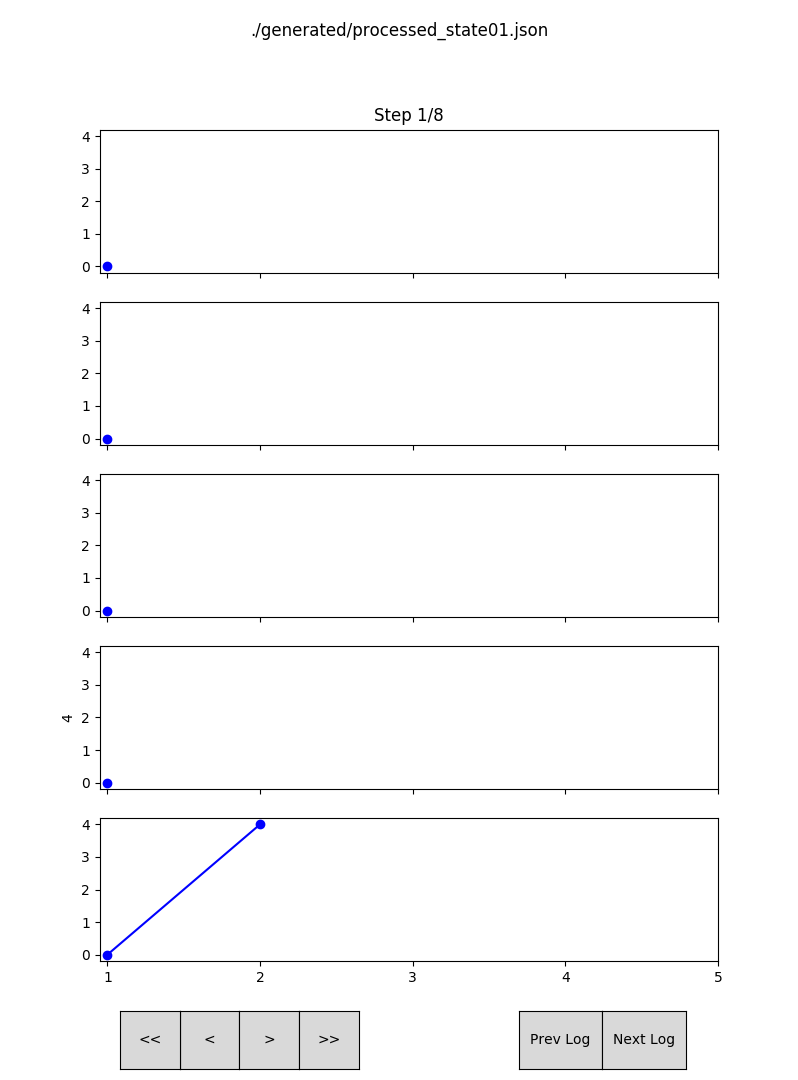

In [8]:
import visualization
%matplotlib notebook 
visualization.main()